# Implementing EGM solver for Deaton model

- Complete the code in the cells below marked with `???`
- Make sure you understand each step
- Run the notebook cells to test your implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.stats import lognorm


class deaton():
  '''Implementation of the stochastic Deaton consumption-savings problem with random income.'''

  def __init__(self, Mbar=10, ngrid=50, nquad=10, interpolation='linear', beta=.9, R=1.05, sigma=1.):
    '''Object creator for the stochastic consumption-savings model'''
    self.beta = beta                        # Discount factor
    self.R = R                              # Gross interest
    self.sigma = sigma                      # Param in log-normal income distribution
    self.Mbar = Mbar                        # Upper bound on wealth
    self.ngrid = ngrid                      # Number of grid points in the state space
    self.nquad = nquad                      # Number of quadrature points
    self.interpolation = interpolation      # type of interpolation, see below
                                            # state and choice space grids, as well as quadrature points and weights are set with setter functions below

  def __repr__(self):
    '''String representation for the model'''
    return 'Deaton model with beta={:1.3f}, sigma={:1.3f}, gross return={:1.3f}\nGrids: state {} points up to {:1.1f}, quadrature {} points\nThe model is {}solved.'\
           .format(self.beta,self.sigma,self.R,self.ngrid,self.Mbar,self.nquad,'' if hasattr(self,'solution') else 'not ')

  @property
  def ngrid(self):
    '''Property getter for the ngrid parameter'''
    return self.__ngrid

  @ngrid.setter
  def ngrid(self, ngrid):
    '''Property setter for the ngrid parameter'''
    self.__ngrid = ngrid
    epsilon = np.finfo(float).eps                      # smallest positive float number difference
    self.grid = np.linspace(epsilon, self.Mbar, ngrid) # grid for state space

  @property
  def sigma(self):
    '''Property getter for the sigma parameter'''
    return self.__sigma

  @sigma.setter
  def sigma(self, sigma):
    '''Property setter for the sigma parameter'''
    self.__sigma = sigma
    self.__quadrature_setup()     # update quadrature points and weights

  @property
  def nquad(self):
    '''Property getter for the number of quadrature points'''
    return self.__nquad

  @nquad.setter
  def nquad(self, nquad):
    '''Property setter for the number of quadrature points'''
    self.__nquad = nquad
    self.__quadrature_setup()     # update quadrature points and weights

  def __quadrature_setup(self):
    '''Internal function to set up quadrature points and weights,
        depends on sigma and nquad, therefore called from the property setters
        '''
    try:
      # quadrature points and weights for log-normal distribution
      self.quadp, self.quadw = np.polynomial.legendre.leggauss(self.__nquad) # Gauss-Legendre for [-1,1]
      self.quadp = (self.quadp + 1) / 2                                      # rescale to [0,1]
      self.quadp = lognorm.ppf(self.quadp, self.__sigma)                     # inverse cdf
      self.quadw /= 2                                                        # rescale weights as well
    
    except (AttributeError):
      # when __nquad or __sigma are not yet set
      pass

  def utility(self, c):
    '''Utility function'''
    # logit utility
    return np.log(c)

  def marginal_utility(self, c):
    '''Marginal utility function'''
    return 1/c

  def inverse_marginal_utility(self, u):
    '''Marginal utility function'''
    return 1/u     # used for EGM step 4

  def next_period_wealth(self, M, c, y):
    '''Next period budget'''
    if self.nquad > 1: # for reference, intial default is 10, so ten points we use to approximate?
      # stochastic income case
      return self.R*(M-c)+y                       # next period wealth
    else:
      # use np.zeros(shape=y.shape) in place of y to revert the nquad=0 case for no income
      return self.R * (M - c) + np.zeros(shape=y.shape) # next period wealth without income

  def interp_func(self, x, f):
    '''Returns the interpolation function for given data'''
    if self.interpolation == 'linear':
      return interpolate.interp1d(x, f, kind='slinear', fill_value="extrapolate")
    elif self.interpolation == 'quadratic':
      return interpolate.interp1d(x, f, kind='quadratic', fill_value="extrapolate")
    elif self.interpolation == 'cubic':
      return interpolate.interp1d(x, f, kind='cubic', fill_value="extrapolate")
    elif self.interpolation == 'polynomial':
      p = np.polynomial.polynomial.polyfit(x, f, self.ngrid_state - 1)
      return lambda x: np.polynomial.polynomial.polyval(x, p)
    else:
      print('Unknown interpolation type')
      return None


In [2]:
# Run the following tests to see that the modelling object works as intended
# - initialize the model
model = deaton()
print(model)
# - explore how quadrature points and weights change with sigma and nquad
print('Quadrature points and weights (baseline)',model.quadp,model.quadw,sep='\n')
model2 = deaton(nquad=20)
print(f'Quadrature points and weights (nquad={model.nquad})',model2.quadp,model2.quadw,sep='\n')
model3 = deaton(sigma=2.0)
print(f'Quadrature points and weights (sigma={model.sigma})',model3.quadp,model3.quadw,sep='\n')


Deaton model with beta=0.900, sigma=1.000, gross return=1.050
Grids: state 50 points up to 10.0, quadrature 10 points
The model is not solved.
Quadrature points and weights (baseline)
[0.10808711 0.22426767 0.37037277 0.56379802 0.82887795 1.20645023
 1.77368483 2.6999825  4.45895742 9.25179704]
[0.03333567 0.07472567 0.10954318 0.13463336 0.14776211 0.14776211
 0.13463336 0.10954318 0.07472567 0.03333567]
Quadrature points and weights (nquad=10)
[ 0.06700331  0.1228722   0.18135407  0.24607771  0.3193444   0.40338206
  0.50072989  0.61449788  0.74865283  0.90841015  1.10082434  1.33573261
  1.6273449   1.99708468  2.47903933  3.1314155   4.06375694  5.51407521
  8.1385372  14.92463562]
[0.008807   0.02030071 0.03133602 0.04163837 0.05096506 0.05909727
 0.06584432 0.07104805 0.07458649 0.07637669 0.07637669 0.07458649
 0.07104805 0.06584432 0.05909727 0.05096506 0.04163837 0.03133602
 0.02030071 0.008807  ]
Quadrature points and weights (sigma=1.0)
[1.16828232e-02 5.02959887e-02 1.3717

In [3]:
def solve_egm(m, maxiter=500, tol=1e-4, callback=None):
  '''Solves the model using EGM (successive approximations of efficient Coleman-Reffet operator)
        Callback function is invoked at each iteration with keyword arguments.
    '''
  # grid on savings using the model grid parameters
  A = np.linespace(0, m.Mbar, m.ngrid) # Mbar is upper bound in the model set before
  # linear interpolation function
  interp = lambda x, f: interpolate.interp1d(x, f, kind='slinear', fill_value="extrapolate")
  # initial policy and value function
  c0 = interp([0, m.Mbar], [0, m.Mbar])
  V0 = m.utility(m.grid)
  # main iteration loop
  for iter in range(maxiter):
    # EGM step
    # matrix with A in axis=0, y/quadpoints in axis=1
    M1 = self.next_period_wealth(M = A[:, np.newaxis], c = 0, y = m.quadp[np.newaxis, :])
    # consumption at next period wealth, 3-dim array
    c1 = np.maximum(c0(M1), m.grid[0])
    # marginal utility in the RHS
    mu = m.marginal_utility(c1)
    # RHS of Euler equation
    RHS = m.beta * m.R * np.dot(mu, m.quadw) # np.dot is numpy's matrix multiplication
    # Initialize new consumption and wealth arrays
    c = np.empty(m.ngrid + 1, dtype=float) # force c, M to be float, not integer, whihc would happen otherwise when assigning zero i following lines
    M = np.empty(m.ngrid + 1, dtype=float)
    # Set first elements in both to zero (credit constrained region)
    c[0], M[0] = 0, 0
    # current period consumption (vector starting from the second element)
    c[1:] = m.inverse_marginal_utility(RHS)
    # vector of endogenous points on M (starting from second element)
    M[1:] = c[1:] + A # 'A' should already have the right size
    # updated policy function
    c1 = interp(M, c)
    # vector representation of policy function
    c1grid = c1(m.grid)
    # ALSO compute the value function
    # matrix of next period wealth, states in axis=0, quadpoint in axis=1
    M1 = m.next_period_wealth(m.grid[:, np.newaxis], c1grid[:, np.newaxis], m.quadp[np.newaxis, :])
    # interpolcation for the value function
    interfunc = m.interp_func(m.grid, V0)
    # value function at next period wealth
    V = interfunc(M1)
    # expected value function, vector
    EV = np.dot(V, m.quadw)
    # maximand of Bellman equation, column-vector
    V1 = m.utility(c1grid) + m.beta * EV
    # convergence check
    err = np.amax(np.abs(c1grid - c0(m.grid)))
    # callback for making plots
    if callback: callback(iter=iter, model=m, value=V1, policy=c1grid, err=err)
    if err < tol:
      break   # converged!
              # prepare for the next iteration
    c0, V0 = c1, V1
  else:
              # when iter went up to maxiter
    raise RuntimeError('No convergence: maximum number of iterations achieved!')
              # save the model solution to the object
  m.solution = {'value': V1, 'policy': c1grid, 'solver': 'egm'}
  # return value and consumption over fixed grid for plotting
  return V1, c1grid


In [4]:
# Time the solver of the model
%timeit solve_egm(model)

AttributeError: module 'numpy' has no attribute 'linespace'

In [5]:
def solve_plot(model, **kvarg):
  '''Illustrate solution
        Inputs: solver (string), and any inputs to the solver
    '''
  fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))
  ax1.grid(visible=True, which='both', color='0.65', linestyle='-')
  ax2.grid(visible=True, which='both', color='0.65', linestyle='-')
  ax1.set_title('Value function convergence')
  ax2.set_title('Policy function convergence')
  ax1.set_xlabel('Wealth, M')
  ax2.set_xlabel('Wealth, M')
  ax1.set_ylabel('Value function')
  ax2.set_ylabel('Policy function')

  def callback(**kwargs):
    print('|', end='')
    grid = kwargs['model'].grid
    v = kwargs['value']
    c = kwargs['policy']
    ax1.plot(grid[1:], v[1:], color='k', alpha=0.25)
    ax2.plot(grid, c, color='k', alpha=0.25)

  V, c = solve_egm(model, callback=callback, **kvarg)
  # add solutions
  ax1.plot(model.grid[1:], V[1:], color='r', linewidth=2.5)
  ax2.plot(model.grid, c, color='r', linewidth=2.5)
  plt.show()



AttributeError: module 'numpy' has no attribute 'linespace'

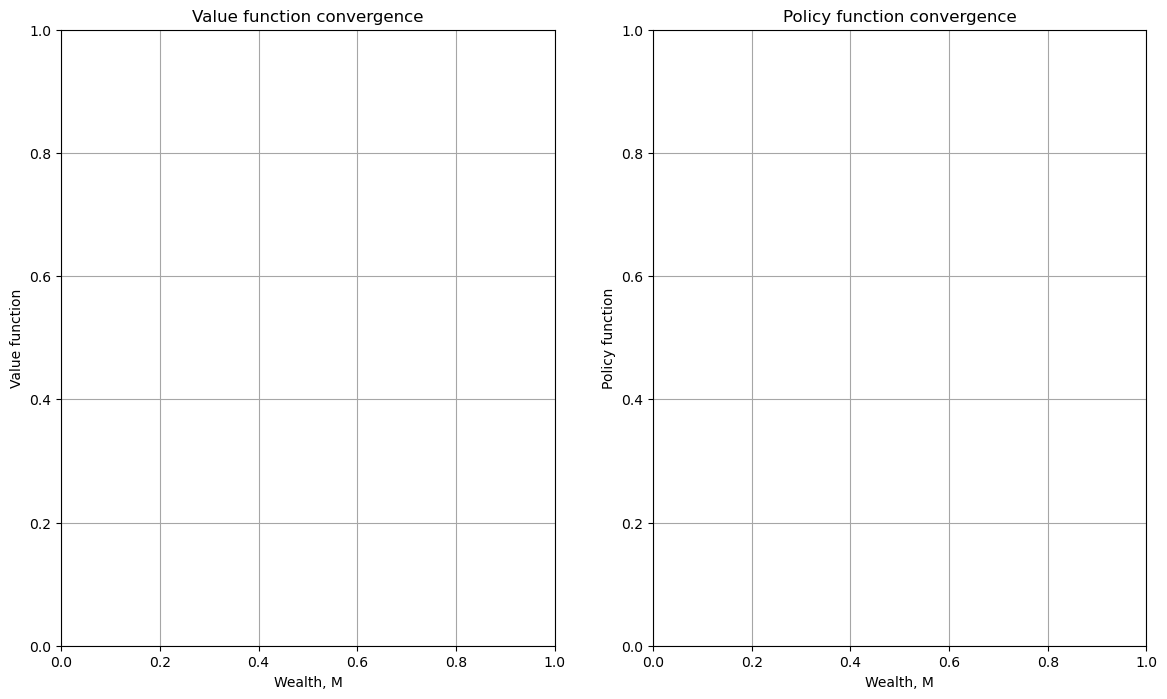

In [6]:
# Illustrate the convergence of the EGM solver
solve_plot(model)

# Now change some parameters the model and observe how convergence changes:
# - for a higher discount factor
# - for a higher income variance


In [29]:
def simulator(model, init_wealth=1, T=10, seed=None, plot=True):
  '''Simulation of the model for given number of periods from given initial conditions'''
  assert hasattr(model, 'solution'), 'Need to solve the model before simulating!'
  if seed != None:
    # fix the seed if asked
    np.random.seed(seed)
  # flat np array of initial wealth
  init_wealth = np.asarray(init_wealth).ravel()
  # number of trajectories to simulate
  N = init_wealth.size
  # initialize storage for simulated data
  sim = {'M': np.empty((N, T + 1)), 'c': np.empty((N, T + 1))}
  # initial wealth in the first column
  sim['M'][:, 0] = init_wealth
  # interpolation function for policy function
  inter = model.interp_func(model.grid, model.solution['policy'])
  for t in range(T + 1):
    # optimal consumption in period t
    sim['c'][:, t] = inter(sim['M'][:, t])
    if t < T:
      # draw random income
      y = lognorm.rvs(model.sigma, size=N)
      # next period wealth
      sim['M'][:, t + 1] = model.next_period_wealth(sim['M'][:, t], sim['c'][:, t], y)
  if plot:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
    ax1.set_title('Simulated wealth and consumption trajectories')
    ax1.set_ylabel('Wealth')
    ax2.set_ylabel('Consumption')
    ax2.set_xlabel('Time period in the simulation')
    for ax in (ax1, ax2):
      ax.grid(visible=True, which='both', color='0.95', linestyle='-')
    for i in range(N):
      ax1.plot(sim['M'][i, :], alpha=0.75)
      ax2.plot(sim['c'][i, :], alpha=0.75)
    plt.show()
  # return simulated data
  return sim


In [ ]:
# Run the simulator of the model
# - simulate 5 trajectories for 20 periods from initial wealth of 1
# - simulate 10 trajectories for 25 periods from initial wealths of 0.0
# - simulate 3 trajectories for 15 periods from initial wealths of 1.0, and again for a different value of the discount factor; remember to use the same random draws. Compare the results.